In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial as spatial
from Helpers import helpers, twod_laplace

/Users/tjibbevanderende/anaconda3/envs/notebook-thesis/lib/python3.8/site-packages/art/estimators/certification/__init__.py:14: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [2]:
plain_df, perturbed_df = helpers.load_plain_and_perturbed_dataset(0.5, import_path="../data/heart-dataset/heart_numerical.csv", perturbed_path="../ExperimentRunners/data/nd-laplace-truncated/heart-dataset/")

In [3]:
plain_df = plain_df.drop(columns=['class'])
plain_df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks
0,120.0,0.0,0.0,0.0,0.0,64.0,62.0,126.0,2.0
1,132.0,4.0,0.0,4.0,2.0,130.0,68.0,198.0,6.0
2,133.0,2.0,0.0,5.0,2.0,130.0,68.0,198.0,5.0
3,134.0,2.0,0.0,6.0,2.0,117.0,53.0,170.0,11.0
4,132.0,4.0,0.0,5.0,0.0,117.0,53.0,170.0,9.0


In [4]:
plain_df_2d = plain_df.loc[:, ['baseline value', 'histogram_min']]
perturbed_df_2d = perturbed_df.loc[:, ['baseline value', 'histogram_min']]
plain_df_2d.head()

,baseline value,histogram_min
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


In [5]:
import random
from sklearn.preprocessing import MinMaxScaler

def get_Z_outside_domain_X(plain_df, perturbed_df):
    """tree = spatial.KDTree(plain_df)
    # Query the KDTree with dataset1 to find the closest points in dataset2
    _, closest_indices = tree.query(perturbed_df)
    # Check if each point in dataset1 is within the domain of dataset2
    in_domain = np.logical_and.reduce([np.logical_and(perturbed_df[:, dim] >= plain_df[:, dim].min(), perturbed_df[:, dim] <= plain_df[:, dim].max()) for dim in range(perturbed_df.shape[1])])

    # Create a mask for points outside the domain of dataset2
    outside_domain_mask = np.logical_not(in_domain)
    return outside_domain_mask"""
    outside_domain_mask = np.logical_or.reduce([np.logical_or(perturbed_df[:, dim] <= plain_df[:, dim].min(), perturbed_df[:, dim] >= plain_df[:, dim].max()) for dim in range(perturbed_df.shape[1])])
    return outside_domain_mask

def get_radius_and_perturbation(plain_df, epsilon):
    data = {'r': [], 'x': [], 'y': []}
    # loop through each record
    for row in plain_df.values:
        p = random.random()
        theta = np.random.rand()*np.pi*2
        r = twod_laplace.inverseCumulativeGamma(epsilon, p) # draw radius distance
        private_point = twod_laplace.addVectorToPoint(row, r, theta)
        data['r'].append(r)
        data['x'].append(private_point[0])
        data['y'].append(private_point[1])

    return pd.DataFrame(data)

def transform(dataframe: pd.DataFrame, scaler: MinMaxScaler):
    return pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

def inverse_transform(dataframe: pd.DataFrame, scaler: MinMaxScaler):
    return pd.DataFrame(scaler.inverse_transform(dataframe), columns=dataframe.columns)



In [6]:
tree = spatial.KDTree(plain_df_2d)
query_data = tree.query_ball_point([132.0,4.0], r=0.3)
plain_df_2d.iloc[query_data]

,baseline value,histogram_min


In [7]:
min_max_scaler = MinMaxScaler(feature_range=[-1,1])
min_max_scaler_perturbed = MinMaxScaler(feature_range=[-1,1])


In [8]:
perturbed_data_with_r = get_radius_and_perturbation(plain_df_2d, 0.5)
perturbed_data_with_r.head()

,r,x,y
0,4.791456,115.387371,60.703193
1,0.362260,131.676912,68.163849
2,4.377104,137.356524,67.576042
3,2.550304,131.550518,53.709993
4,16.877422,131.670922,69.874213


In [9]:
outside_domain_mask = get_Z_outside_domain_X(plain_df_2d.values, perturbed_data_with_r.drop(columns=['r']).values)


In [10]:
perturbed_data_with_r_outside_domain = perturbed_data_with_r.drop(columns=['r'])[outside_domain_mask]
perturbed_data_with_r_outside_domain = pd.concat([perturbed_data_with_r['r'][outside_domain_mask], perturbed_data_with_r_outside_domain], axis=1)

In [11]:
perturbed_data_with_r_outside_domain.head()

,r,x,y
5,7.162774,131.435775,43.311945
6,8.223098,127.975292,44.403373
29,3.655124,129.532868,47.303114
31,2.246054,133.506882,48.334447
35,2.276868,121.656304,49.437699


In [12]:
# perturbed_data_with_r_outside_domain_scaled = pd.DataFrame(min_max_scaler.fit_transform(perturbed_data_with_r_outside_domain), columns=perturbed_data_with_r_outside_domain.columns)


In [13]:
random_point = perturbed_data_with_r_outside_domain.iloc[2]
plain_tree = spatial.KDTree(plain_df_2d)
perturbed_query_data = plain_tree.query_ball_point([random_point['x'], random_point['y']], r=random_point['r'])

/Users/tjibbevanderende/anaconda3/envs/notebook-thesis/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


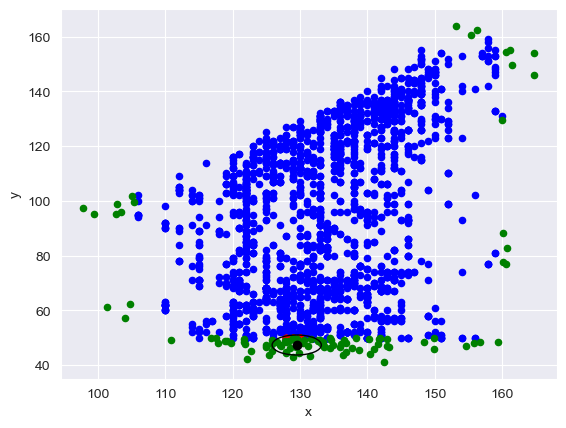

In [14]:
fig, ax = plt.subplots()
plain_df_2d.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', ax=ax)
plain_df_2d.iloc[perturbed_query_data].plot(kind='scatter', x='baseline value', y='histogram_min', color='red', ax=ax)
perturbed_data_with_r_outside_domain.plot(kind='scatter', x='x', y='y', color='green', ax=ax)
ax.add_patch(plt.Circle((random_point['x'], random_point['y']), random_point['r'], color='black', fill=False))
ax.scatter(random_point['x'], random_point['y'], color='black')

In [15]:
perturbed_data_with_r_remapped = helpers.truncate_n_dimensional_laplace_noise(perturbed_data_with_r.drop(columns=['r']).values, plain_df_2d.values, grid_size=10, columns=['x', 'y'], include_indicator=True)
# perturbed_data_with_r_remapped = pd.DataFrame(perturbed_data_with_r_remapped, columns=['baseline value', 'histogram_min'])
perturbed_data_with_r_remapped = pd.concat([perturbed_data_with_r['r'], perturbed_data_with_r_remapped], axis=1)
perturbed_data_with_r_outside_domain_remapped = perturbed_data_with_r_remapped[perturbed_data_with_r_remapped['is_remapped']]
print(perturbed_data_with_r_remapped.shape, perturbed_data_with_r_outside_domain_remapped.shape)

(2126, 4) (231, 4)


In [16]:
"""perturbed_data_with_r_outside_domain_remapped = pd.concat([perturbed_data_with_r['r'][outside_domain_mask], perturbed_data_with_r_outside_domain_remapped], axis=1)
perturbed_data_with_r_outside_domain_remapped.rename(columns={'baseline value': 'x', 'histogram_min': 'y'}, inplace=True)
perturbed_data_with_r_outside_domain_remapped.head()"""
perturbed_data_with_r_remapped.head()


,r,x,y,is_remapped
0,4.791456,118.000000,62.111111,True
1,0.362260,131.676912,68.163849,False
2,4.377104,137.356524,67.576042,False
3,2.550304,131.550518,53.709993,False
4,16.877422,131.670922,69.874213,False


/Users/tjibbevanderende/anaconda3/envs/notebook-thesis/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='x', ylabel='y'>

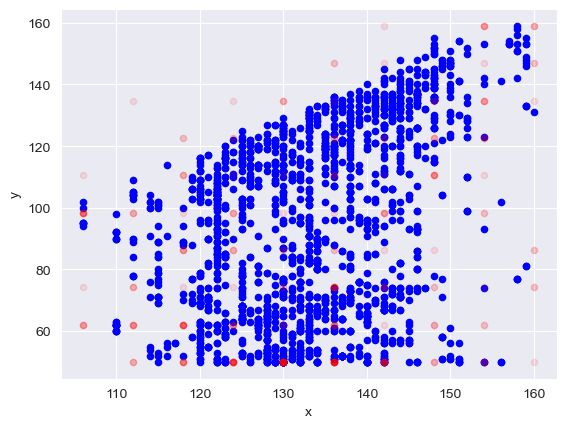

In [17]:
fig, ax = plt.subplots()
plain_df_2d.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', ax=ax)
perturbed_data_with_r_outside_domain_remapped.plot(kind='scatter', x='x', y='y', color='red', ax=ax, alpha=0.1)


In [18]:
import math
import scipy.spatial as spatial


def calculate_distance(point1, point2):
    #return spatial.distance.euclidean(point1, point2)  # Euclidean distance as an example
    return np.linalg.norm(point1 - point2)

def remap_point(x, z_popularity, fake_data, real_data, radius, epsilon, plain_tree, w_x):
    w_x = len(w_x) + len(z_popularity)
    #w_q_sum = sum([len(calculate_popularity(q, real_data, radius)) for q in Q_r(x, z, real_data, radius)])
    q = Q_r(x, real_data, radius, plain_tree)
    w_q_sum = len(q)

    # q_calc = (w_q_sum * math.exp(-epsilon * calculate_distance(q, z)))
    #print(w_q_sum)
    distance_xz = calculate_distance(x, fake_data)
    #epsilon_offset = 1e-6  # Small offset to avoid division by zero or infinite results
    
    remapped_value = (w_x * math.exp(-epsilon * distance_xz)) / w_q_sum if w_q_sum > 0 else 0
    
    return remapped_value

def Q_r(x, points, radius, kd_tree=None):
    kdtree = spatial.KDTree(points) if kd_tree is None else kd_tree
    indices = kdtree.query_ball_point((x), radius)
    return [points[i] for i in indices]

def find_new_r_for_perturbed_datas_outside_domain(perturbed_data: pd.DataFrame, plain_df: pd.DataFrame, epsilon=0.1):
    tree = spatial.KDTree(plain_df)
    perturbed_data_with_Q = perturbed_data.copy()
    for index, point in perturbed_data_with_Q.iterrows():
        x = plain_df.iloc[index]
        new_r = { 'x_new': [], 'y_new': []}
        for column in ['x', 'y']:
            #print(point[column], x[column])
            polularity_x = Q_r([x[column]], [point[column]], plain_df[column].values, point['r'], plain_tree)
            #new_r[f"{column}_new"].append(remap_point([plain_df.loc[index,column]], [point[column]], plain_df[column].values, point['r'], epsilon, tree, w_x=polularity_x))
            for x_q in polularity_x:
                print(x_q)
                new_r[f"{column}_new"].append(remap_point([plain_df.loc[x_q, column]], [point[column]], plain_df[column].values, point['r'], epsilon, tree, w_x=polularity_x))

            coefficients = [x_new * x[column] for x_new in new_r[f"{column}_new"]] 
            sum_coefficients = sum(coefficients)
            
            probabilities = [coeff / sum_coefficients for coeff in coefficients]
            if(sum_coefficients > 0): 
                averaged = np.average(polularity_x, axis=0, weights=probabilities)
                averaged = averaged if averaged is not np.nan else point[column]
                perturbed_data_with_Q.loc[index, f"{column}_new"] = averaged
            else:
                perturbed_data_with_Q.loc[index, f"{column}_new"] = point[column]
        
    return perturbed_data_with_Q; 

In [19]:
plain_df_2d.head()
plain_df_2d_renamed = plain_df_2d.rename(columns={'baseline value': 'x', 'histogram_min': 'y'}, inplace=False)
plain_df_2d_renamed.head()

,x,y
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


In [20]:
# counts = find_new_r_for_perturbed_datas_outside_domain(perturbed_data_with_r_outside_domain_remapped.drop(columns=['is_remapped']), plain_df_2d_renamed, epsilon=0.5)

#counts = counts.where(counts['Q_r'] > 0).dropna()

In [21]:
#counts.head()

In [22]:
#print(counts['y_new'].max(), plain_df_2d_renamed['y'].max(), counts['y_new'].min(), plain_df_2d_renamed['y'].min(), perturbed_data_with_r_outside_domain_remapped['y'].max(), perturbed_data_with_r_outside_domain_remapped['y'].min())
#print(counts['x_new'].max(), plain_df_2d_renamed['x'].max(), counts['x_new'].min(), plain_df_2d_renamed['x'].min(), perturbed_data_with_r_outside_domain_remapped['x'].max(), perturbed_data_with_r_outside_domain_remapped['x'].min())

In [23]:
plain_df_2d_renamed.head()

,x,y
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


$$  \sigma(x) = \frac{w(x)e^{-\epsilon d(x, z)}}{w(q)e^{-\epsilon d(q, z)}}$$

In [24]:
"""fig, ax = plt.subplots()
plain_df_2d_renamed.plot(kind='scatter', x='x', y='y', color='blue', ax=ax, alpha=0.1)

counts.plot(kind='scatter', x='x_new', y='y_new', color='green', ax=ax)
counts.plot(kind='scatter', x='x', y='y', color='red', ax=ax)
ax.legend(['Plain', 'Optimal remapped', 'Grid-mapped (outside domain)'])"""

"fig, ax = plt.subplots()\nplain_df_2d_renamed.plot(kind='scatter', x='x', y='y', color='blue', ax=ax, alpha=0.1)\n\ncounts.plot(kind='scatter', x='x_new', y='y_new', color='green', ax=ax)\ncounts.plot(kind='scatter', x='x', y='y', color='red', ax=ax)\nax.legend(['Plain', 'Optimal remapped', 'Grid-mapped (outside domain)'])"

In [25]:
def get_Z_outside_domain_X(plain_df, perturbed_df):
    # tree = spatial.KDTree(plain_df)
    # Query the KDTree with dataset1 to find the closest points in dataset2
    # _, closest_indices = tree.query(perturbed_df)
    # Check if each point in dataset1 is within the domain of dataset2
    in_domain = np.logical_and.reduce([np.logical_and(perturbed_df[:, dim] >= plain_df[:, dim].min(), perturbed_df[:, dim] <= plain_df[:, dim].max()) for dim in range(perturbed_df.shape[1])])

    # Create a mask for points outside the domain of dataset2
    outside_domain_mask = np.logical_not(in_domain)
    return outside_domain_mask

"""
    Optimal remapping algoritm.
    Important: Should have a "r" (radius/ radial distance) which is used to remap the data.
    @param perturbed_data: The perturbed data to be remapped. It should be grid-mapped already.
    @param plain_df: The plain data to be used for remapping. (Used to determine crowdness)
"""
def optimal_remapping (perturbed_data: pd.DataFrame, plain_df: pd.DataFrame, epsilon=0.1):
    tree = spatial.KDTree(plain_df)
    perturbed_data_copy = perturbed_data.copy()
    if perturbed_data.columns.isin(['is_remapped']).any():
        perturbed_data_copy = perturbed_data_copy[perturbed_data_copy['is_remapped']]
        perturbed_data_copy = perturbed_data_copy.drop(columns=['is_remapped'])
    if not perturbed_data_copy.columns.isin(['r']).any():
        raise ValueError("Perturbed data should have a column named 'r' which is the radius of the grid.")
    if not perturbed_data_copy.shape[1] -1 is plain_df.shape[1]:
        raise ValueError("Perturbed data should have the same number of columns as plain data.")
    if not perturbed_data_copy.columns.drop(labels=['r']).isin(plain_df.columns).all():
        raise ValueError("Perturbed data should have the same columns as plain data.")

    
    ##truncated_perturbed_data = helpers.truncate_n_dimensional_laplace_noise(perturbed_data_copy, epsilon)
    for index, private_data_point in perturbed_data_copy.iterrows(): # loop through each point outside the domain
        non_private_data_point = plain_df.iloc[index] # get the corresponding plain data point
        list_sigma = []
        #print(non_private_data_point, private_data_point)
        # calculate w_x
        polularity_x = Q_r(non_private_data_point.values, plain_df.values, private_data_point['r'], tree)
        popularity_z = Q_r(private_data_point[plain_df.columns].values, plain_df.values, private_data_point['r'], tree)
        # for every point in a radius r around the non-private data point, calculate the new r.
        for x_q in polularity_x:
            #print(x_q)
            # new_r[f"{column}_new"].append(remap_point([plain_df.loc[x_q, column]], [point[column]], plain_df[column].values, point['r'], epsilon, tree, w_x=polularity_x))
            list_sigma.append(remap_point(x_q, popularity_z, private_data_point[plain_df.columns].values, plain_df.values, private_data_point['r'], epsilon, tree, w_x=polularity_x))

        coefficients = [x_new * non_private_data_point for x_new in list_sigma] 
        #print(coefficients)
        sum_coefficients = sum(coefficients)
        
        probabilities = np.array([coeff / sum_coefficients for coeff in coefficients]) # calculate the probabilities using the coefficients
        if(sum_coefficients[sum_coefficients > 0].all()):
            perturbed_data_copy.loc[index, plain_df.columns] = np.average(polularity_x, axis=0, weights=probabilities) # calculate the new value for the point based on the average with weightes probabilities.
        #print(np.array(probabilities))

    return perturbed_data_copy

In [26]:
#perturbed_data_with_r_remapped = helpers.truncate_n_dimensional_laplace_noise(perturbed_data_with_r.drop(columns=['r']).values, plain_df_2d.values, grid_size=10)
#perturbed_data_with_r_remapped = pd.DataFrame(perturbed_data_with_r_remapped, columns=['x', 'y'])
#perturbed_data_with_r_remapped = pd.concat([perturbed_data_with_r['r'], perturbed_data_with_r_remapped], axis=1)
perturbed_data_with_r_remapped.head()

,r,x,y,is_remapped
0,4.791456,118.000000,62.111111,True
1,0.362260,131.676912,68.163849,False
2,4.377104,137.356524,67.576042,False
3,2.550304,131.550518,53.709993,False
4,16.877422,131.670922,69.874213,False


In [27]:
optimal_remapped_data = optimal_remapping(perturbed_data_with_r_remapped, plain_df_2d_renamed, epsilon=0.5)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
optimal_remapped_data.plot(kind='scatter', x='x', y='y', color='green', ax=ax, alpha=1)
plain_df_2d_renamed.plot(kind='scatter', x='x', y='y', color='blue', ax=ax, alpha=0.1)
perturbed_data_with_r_outside_domain_remapped.plot(kind='scatter', x='x', y='y', color='red', ax=ax, alpha=0.1)
ax.legend(['Optimal remapped', 'Non-private', 'Grid-mapped (outside domain)'])

In [ ]:
plain_df_2d_renamed.min()

In [ ]:
def mechanism_design(plain_df, perturbed_df, grid_size=10, columns=['x', 'y'], epsilon=0.1):
    perturbed_df_with_grid_remapping = helpers.truncate_n_dimensional_laplace_noise(perturbed_df.drop(columns=['r']).values, plain_df.values, grid_size=grid_size, columns=columns, include_indicator=True)
    #perturbed_df_find_grid_remappings = perturbed_df_with_grid_remapping[perturbed_df_with_grid_remapping['is_remapped']]
    perturbed_df_find_grid_remappings_with_r = pd.concat([perturbed_df['r'], perturbed_df_with_grid_remapping], axis=1)
    perturbed_df_optimal_remapping = optimal_remapping(perturbed_df_find_grid_remappings_with_r, plain_df, epsilon=epsilon)
    return perturbed_df_optimal_remapping

In [ ]:
perturbed_df_optimal_remapping = mechanism_design(plain_df_2d_renamed, perturbed_data_with_r)

In [ ]:
perturbed_df_optimal_remapping.plot(kind='scatter', x='x', y='y', color='green', alpha=0.1)

## 3D Variant

In [ ]:
plain_df_3d = plain_df.loc[:, ['baseline value', 'histogram_min', 'accelerations']]
perturbed_df_3d = perturbed_df.loc[:, ['baseline value', 'histogram_min', 'accelerations']]
perturbed_df_3d.head()

In [ ]:
from Helpers import threed_laplace

epsilon = 0.5

In [ ]:
def generate_3D_noise_for_dataset(plain_df:pd.DataFrame, epsilon):
    Z = []
    R = []
    X = np.array(plain_df)
    for x in X: 
        noise = generate_3D_noise(epsilon)
        z = x + noise[:3]
        Z.append(z)
        R.append(noise[3])
    return pd.concat((pd.DataFrame(Z, columns=plain_df.columns), pd.DataFrame(R, columns=['r'])), axis=1)
def generate_3D_noise(epsilon): 
    polar_angle, azimuth, _ = threed_laplace.generate_unit_sphere() # theta, psi
    r = threed_laplace.generate_r(epsilon)
    # theta = 2 * np.pi * u[0]
    #theta = np.random.rand() * np.pi
    #phi = np.arccos(2 * u[1] - 1)
    #phi = np.random.rand() * np.pi*2 # 
    # https://mathworld.wolfram.com/SphericalCoordinates.html formula 4/5/6
    x = r * np.sin(polar_angle) * np.sin(azimuth)
    y = r * np.sin(polar_angle) * np.cos(azimuth)
    z = r * np.cos(polar_angle)
    return x, y, z, r

In [ ]:
perturbed_df_3d = generate_3D_noise_for_dataset(plain_df_3d, epsilon)
#perturbed_df_3d = pd.DataFrame(perturbed_df_3d, columns=['baseline value', 'histogram_min', 'accelerations'])
perturbed_df_3d.head()

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(plain_df_3d['baseline value'], plain_df_3d['histogram_min'], plain_df_3d['accelerations'], color='blue', alpha=0.1)
ax.scatter3D(perturbed_df_3d['baseline value'], perturbed_df_3d['histogram_min'], perturbed_df_3d['accelerations'], color='red', alpha=0.1)
#plain_df_3d.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', alpha=0.1, ax=ax)
ax.legend(['Plain', 'Optimal remapped', 'Grid-mapped (outside domain)'])

In [ ]:
perturbed_df_3d_grid_remapped = helpers.truncate_n_dimensional_laplace_noise(perturbed_df_3d.drop(columns=['r']).values, plain_df_3d.values, grid_size=10, columns=['baseline value', 'histogram_min', 'accelerations'], include_indicator=True)
perturbed_df_3d_outside_domain = perturbed_df_3d[perturbed_df_3d_grid_remapped['is_remapped']]
print(perturbed_df_3d_outside_domain.shape, perturbed_df_3d_grid_remapped.shape)

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.scatter3D(perturbed_df_3d_outside_domain['baseline value'], perturbed_df_3d_outside_domain['histogram_min'], perturbed_df_3d_outside_domain['accelerations'], color='blue', alpha=0.1)
#ax.scatter3D(plain_df_3d['baseline value'], plain_df_3d['histogram_min'], plain_df_3d['accelerations'], color='green', alpha=0.1)
ax.scatter3D(perturbed_df_3d_grid_remapped['baseline value'], perturbed_df_3d_grid_remapped['histogram_min'], perturbed_df_3d_grid_remapped['accelerations'], color='red', alpha=0.1)
ax.legend(['Grid-mapped (outside domain)']) 
#ax.scatter3D(perturbed_df_3d_grid_remapped['baseline value'], perturbed_df_3d_grid_remapped['histogram_min'], perturbed_df_3d_grid_remapped['accelerations'], color='red', alpha=0.1)
#perturbed_df_3d_grid_remapped.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', alpha=0.1, ax=ax)

In [ ]:
perturbed_df_remapped = mechanism_design(plain_df_3d, perturbed_df_3d, epsilon=0.5, columns=plain_df_3d.columns)

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(perturbed_df_remapped['baseline value'], perturbed_df_remapped['histogram_min'], perturbed_df_remapped['accelerations'], color='green', alpha=1)
ax.scatter3D(plain_df_3d['baseline value'], plain_df_3d['histogram_min'], plain_df_3d['accelerations'], color='blue', alpha=0.1)

ax.legend(['Optimal remapped', 'Non-private', 'Grid-mapped (outside domain)'])


## Trying mechanism design

In [ ]:
from Helpers import helpers 

plain_df, perturbed_df = helpers.load_plain_and_perturbed_dataset(0.5, import_path="../data/heart-dataset/heart_numerical.csv", perturbed_path="../ExperimentRunners/data/nd-laplace-truncated/heart-dataset/")
plain_df = plain_df.drop(columns=['class'])
plain_df_3d = plain_df.loc[:, ['baseline value', 'histogram_min', 'accelerations']]

In [ ]:
plain_df_3d.head()

In [ ]:
from Helpers.ldp_mechanism import ldp_mechanism

mechanism = ldp_mechanism()
private_dataset_3d = mechanism.randomise(non_private_dataset=plain_df_3d, epsilon=0.5, plot_validation=True)
print(private_dataset_3d.shape, plain_df_3d.shape)

In [ ]:
private_dataset_3d.head()

In [ ]:
plain_df_2d = plain_df.loc[:, ['baseline value', 'histogram_min']]
plain_df_2d.head()

In [ ]:
private_dataset_2d = mechanism.randomise(plain_df_2d, plot_validation=True, epsilon=0.5)
private_dataset_2d.head()

## Trying with lower privacy budget (0.1)

In [ ]:
mechanism_more_private = ldp_mechanism()
private_dataset_2d_more_private = mechanism_more_private.randomise(plain_df_2d, plot_validation=True, epsilon=0.1)

In [ ]:
private_dataset_3d_more_private = mechanism_more_private.randomise(plain_df_3d, plot_validation=True, epsilon=0.1)

In [ ]:
private_dataset_3d_more_private.shape

## Considering seeds dataset

In [ ]:
from Helpers import helpers
plain_seed_df, _ = helpers.load_plain_and_perturbed_dataset(0.5, import_path="../data/seeds-dataset/rq1.csv", perturbed_path="../ExperimentRunners/data/nd-laplace-truncated/seeds-dataset/")
plain_seed_df_without_class = plain_seed_df.drop(columns=['class'])
plain_seed_df_without_class.head()

In [ ]:
from Helpers.ldp_mechanism import ldp_mechanism

mechanism = ldp_mechanism()
private_seed_dataset = mechanism.randomise(non_private_dataset=plain_seed_df_without_class, epsilon=0.5, plot_validation=True)
print(private_seed_dataset.shape, plain_seed_df_without_class.shape)

In [ ]:
mechanism = ldp_mechanism()
private_seed_dataset = mechanism.randomise(non_private_dataset=plain_seed_df_without_class, epsilon=0.1, plot_validation=True)

In [ ]:
mechanism = ldp_mechanism()
plain_seed_df_3d, _ = helpers.load_plain_and_perturbed_dataset(0.5, import_path="../data/seeds-dataset/rq2.csv", perturbed_path="../ExperimentRunners/data/nd-laplace-truncated/seeds-dataset/")
plain_seed_df_3d_without_class  = plain_seed_df_3d.drop(columns=['class'])
plain_seed_df_3d_without_class.head()

In [ ]:
private_seed_dataset_3d = mechanism.randomise(non_private_dataset=plain_seed_df_3d_without_class, epsilon=0.5, plot_validation=True)

In [ ]:
private_seed_dataset_3d

## Using nd-laplace


In [1]:
import Helpers.helpers as helpers
from Helpers.ldp_mechanism import ldp_mechanism

plain_seed_df, _ = helpers.load_plain_and_perturbed_dataset(0.5, import_path="../data/seeds-dataset/rq2-nd.csv", perturbed_path="../ExperimentRunners/data/nd-laplace-truncated/seeds-dataset/")
plain_seed_df.head()

/Users/tjibbevanderende/anaconda3/envs/notebook-thesis/lib/python3.8/site-packages/art/estimators/certification/__init__.py:14: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")
/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:192: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dimensions is 2:
/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:195: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif dimensions is 3:
/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:230: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dimensions is 2:
/Users/tjibbevanderende/Documents/GitHub/notebook/Helpers/ldp_mechanism.py:232: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif dimensions is 3:


,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0


In [2]:
mech_nd = ldp_mechanism()
plain_seed_df_no_class = plain_seed_df.drop(columns=['class'])
plain_seed_df_no_class.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175


Run appropiate mechanism to generate a private dataset...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset using a grid...
          area  perimeter  compactness  length of kernel  width of kernel  \
0    21.180000  17.250000       0.9183          4.899000         3.409444   
1    20.003333  16.712222       0.9183          4.899000         3.409444   
2    21.180000  16.712222       0.8081          5.885667         3.409444   
3    21.180000  15.636667       0.9183          4.899000         3.565333   
4    21.180000  12.410000       0.9183          5.688333         3.565333   
..         ...        ...          ...               ...              ...   
205  21.180000  16.712222       0.9183          4.899000         2.941778   
206  20.003333  12.410000       0.8081          5.096333         2.785889   
207  21.180000  17.250000       0.9183          5.096333         3.253556   
208  21.180000  12.410000       0.8081          4.8990

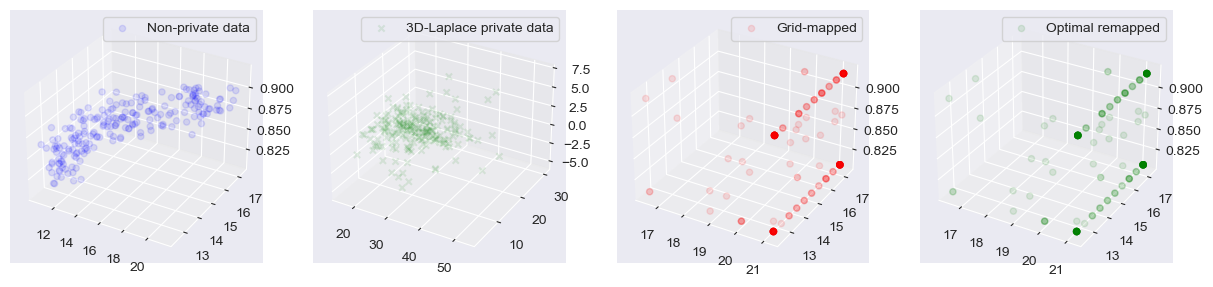

In [3]:
randomized_seed_df = mech_nd.randomise(non_private_dataset=plain_seed_df_no_class, epsilon=0.5, plot_validation=True)

In [4]:
randomized_seed_df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove
0,21.180000,17.250000,0.9183,4.899000,3.409444,2.474189,5.196000
1,20.003333,16.712222,0.9183,4.899000,3.409444,0.765100,4.970333
2,21.180000,16.712222,0.8081,5.885667,3.409444,2.474189,4.744667
3,21.180000,15.636667,0.9183,4.899000,3.565333,2.474189,4.744667
4,21.180000,12.410000,0.9183,5.688333,3.565333,1.619644,5.196000


In [5]:
plain_seed_df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0


Run appropiate mechanism to generate a private dataset...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset using a grid...
      area  perimeter  compactness  length of kernel  width of kernel  \
0    21.18      12.41       0.8081          6.675000         3.253556   
1    21.18      17.25       0.8081          5.293667         3.253556   
2    21.18      17.25       0.8081          6.477667         4.033000   
3    21.18      17.25       0.9183          4.899000         2.785889   
4    21.18      17.25       0.9183          5.096333         3.565333   
..     ...        ...          ...               ...              ...   
205  21.18      12.41       0.8081          4.899000         3.409444   
206  21.18      12.41       0.8081          6.675000         3.409444   
207  21.18      17.25       0.9183          5.491000         3.253556   
208  21.18      12.41       0.8081          5.491000         2.630000   
209  21.18      12.41

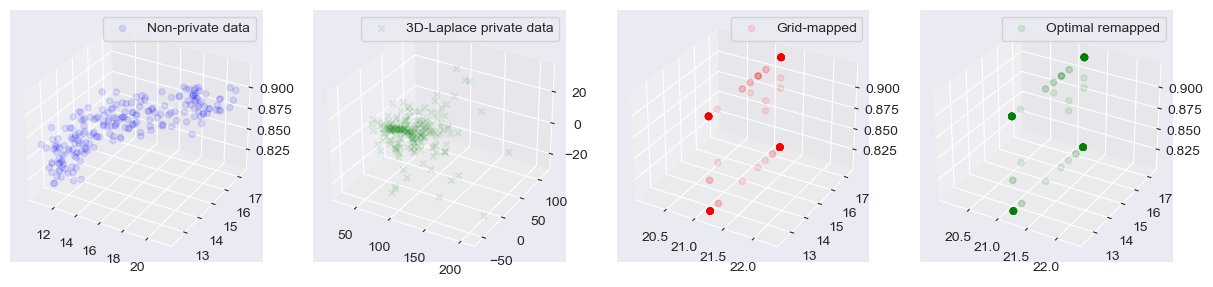

In [6]:
randomized_seed_df_01 = mech_nd.randomise(non_private_dataset=plain_seed_df_no_class, epsilon=0.1, plot_validation=True)


In [7]:
randomized_seed_df_01.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove
0,21.18,12.41,0.8081,6.675000,3.253556,2.474189,5.196000
1,21.18,17.25,0.8081,5.293667,3.253556,0.765100,4.970333
2,21.18,17.25,0.8081,6.477667,4.033000,2.474189,4.970333
3,21.18,17.25,0.9183,4.899000,2.785889,2.474189,4.744667
4,21.18,17.25,0.9183,5.096333,3.565333,1.619644,5.196000


Run appropiate mechanism to generate a private dataset...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset using a grid...
          area  perimeter  compactness  length of kernel  width of kernel  \
0    17.650000  16.174444     0.918300          5.688333         3.253556   
1    16.473333  14.023333     0.808100          5.688333         3.409444   
2    17.650000  12.947778     0.808100          5.688333         3.253556   
3    17.650000  13.485556     0.918300          5.293667         3.409444   
4    17.650000  15.098889     0.918300          5.688333         3.565333   
..         ...        ...          ...               ...              ...   
205  16.473333  15.098889     0.808100          4.899000         2.941778   
206  17.650000  15.098889     0.808100          4.899000         2.941778   
207  16.473333  14.023333     0.918300          5.293667         3.253556   
208  15.296667  12.947778     0.881567          5.0963

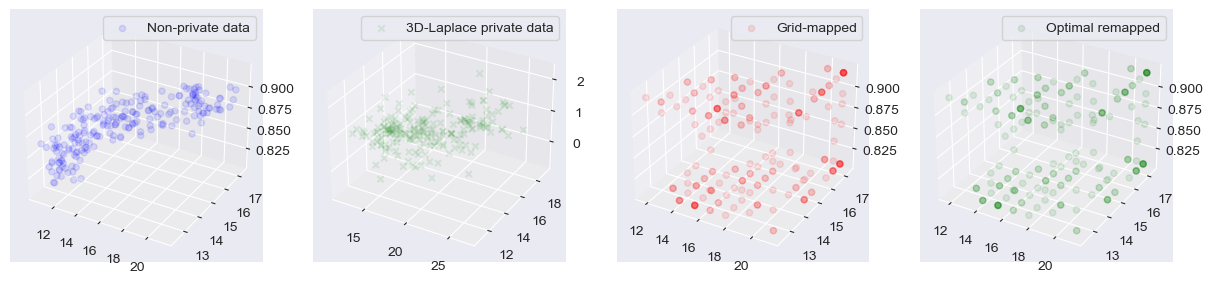

In [10]:
randomized_seed_df_05 = mech_nd.randomise(non_private_dataset=plain_seed_df_no_class, epsilon=2, plot_validation=True)


In [11]:
randomized_seed_df_05.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove
0,17.650000,16.174444,0.9183,5.688333,3.253556,2.474189,5.196000
1,16.473333,14.023333,0.8081,5.688333,3.409444,0.765100,4.970333
2,17.650000,12.947778,0.8081,5.688333,3.253556,2.474189,4.744667
3,17.650000,13.485556,0.9183,5.293667,3.409444,2.474189,4.744667
4,17.650000,15.098889,0.9183,5.688333,3.565333,1.619644,5.196000
